In [1]:
#raw version of the environment and how to make predictions from it
#This is the code that will be transferred to C++ for the microcontroller

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
class UnicycleEnv():

    def __init__(self):
        self.max_speed_disk = 45 
        self.max_speed_wheel = 8.4
        self.max_volt = 12
        self.dt = .01
        self.max_theta = 25 * math.pi/180 
        self.max_phi = 25 * math.pi/180
        self.viewer_pitch = None
        self.viewer_roll = None
        self.t = 0
        self.last_u = None
        self.weight_input = 0
        self.weight_angvel_w = 0
        self.weight_angvel_d = 0
        self.prev_action = None
        self.u = 0

        action_high = np.array([self.max_volt, self.max_volt])
        action_low = -action_high
        observation_high = np.array([self.max_speed_wheel, self.max_speed_disk, 50 , 50 , self.max_phi, self.max_theta])
        observation_low = -observation_high
        
        
        #Runge kutta matrices
        self.ARK5 = np.array([[0,0,0,0,0,0],[1/4,0,0,0,0,0],[3/32,9/32,0,0,0,0],[1932/2197,-7200/2197,7296/2197,0,0,0],[439/216,-8,3680/513,-845/4104,0,0],[-8/27,2,-3544/2565,1859/4104,-11/40,0]])
        self.BRK5 = np.array([16/135,0,6656/12825,28561/56430,-9/50,2/55])
        self.BRK4 = np.array([25/216,0,1408/2565,2197/4101,-1/5,0])
        self.tol = 1e-3
    
        self.state = np.zeros((6, 1))
    

        #The non linear model
    def NL_model_v3(self,dalpha_w, dalpha_d, dphi, dtheta, phi, theta, u):
    
        self.last_u = u # for rendering
        u_w, u_d = u 
        
        t2 = math.cos(theta)
        t3 = t2**2
        t4 = math.sin(theta)
        t5 = theta*2.0
        t6 = math.sin(t5)
        t7 = t4**2
        t8 = math.sin(phi)
        t9 = dphi**2
        t10 = t3**2
        t11 = dtheta**2
        t12 = math.cos(phi)
        t13 = t2*5.270113949764262e136
        t14 = t2*t4*2.9425384197083e135
        t15 = t3*6.83841392796149e136
        t18 = t2*t3*2.611232497919307e136
        t19 = t10*4.084668258920979e136
        t20 = t2*t3*t4*1.460114161456265e135
        t16 = t13+t14+t15-t18-t19-t20+2.879983171105363e136
        t17 = 1.0/t16
        
        new_dalpha_w = t17*(dalpha_d*8.799701459205116e136+dalpha_w*3.273073914696596e151+t8*3.054874977324171e138+t9*2.745784604300393e135-t12*3.741131523359285e137-u_d*3.355805235876581e137-u_w*3.056236531283865e151+dalpha_d*dphi*5.110933045413505e134+dphi*dtheta*4.434845622939034e135-dalpha_d*t2*1.096940029092178e145+dalpha_d*t3*3.637191152945704e147+dalpha_d*t4*7.147565045596023e149+dalpha_d*t6*3.573781361168432e149+dalpha_w*t2*6.973354523360509e151+dalpha_w*t3*1.11917613821661e152+dalpha_w*t4*9.920814586940586e149+dalpha_w*t6*1.672083684579905e150+t2*t8*5.403285701124564e138+t2*t9*8.546396552413335e148+t3*t8*1.260791801283757e149+t3*t9*3.082291665851177e149+t4*t8*4.38882201112563e151+t2*t11*5.198980458965509e149+t4*t9*7.831387532098359e150-t3*t12*2.099879547909213e151+t4*t11*1.963955932906972e151+t6*t9*7.642580937407093e149+t6*t11*4.65228607866632e150-t9*t10*4.623387333236904e149+t10*t12*2.099879547909251e151+t2*u_d*4.183229522200925e145-t3*u_d*1.387059000981349e148-t4*u_d*2.725755676482487e150-t6*u_d*1.362877395248644e150-t2*u_w*6.511377804269218e151-t3*u_w*1.045032005907471e152-t4*u_w*9.263572027676704e149-t6*u_w*1.561310063066676e150+dalpha_d*dphi*t3*2.869299109108257e148+dalpha_d*dphi*t4*5.130389377691243e149+dalpha_d*dphi*t6*1.422570415904624e149-dalpha_d*dphi*t10*2.867173259503638e148+dalpha_d*dtheta*t2*5.995773018682494e148+dalpha_d*dtheta*t4*3.05825282407086e146+dphi*dtheta*t2*6.44230753926698e149+dphi*dtheta*t3*2.075640248828218e150+dphi*dtheta*t4*3.272962051762236e147+dphi*dtheta*t6*1.801090557489944e148-dphi*dtheta*t10*2.075823281462639e150+dalpha_d*t2*t3*3.654230264061639e147-dalpha_d*t4*t7*7.147565045596023e149+dalpha_w*t2*t3*2.775347128028627e151-dalpha_w*t4*t7*9.920814586940409e149+t2*t3*t8*2.230015422084065e149+t2*t3*t9*5.809970216980451e149+t2*t4*t8*2.481324009745926e151-t2*t3*t11*5.202806029440341e149-t2*t4*t12*2.082603305443433e152-t3*t4*t12*3.755373286529812e152-t4*t7*t8*4.38882201112563e151-t4*t7*t9*7.831387532098359e150-t2*t9*t10*9.929936649941362e149-t4*t7*t11*1.455484740767907e151+t4*t9*t10*1.427396486577786e151-t2*t3*u_d*1.393556941685658e148+t4*t7*u_d*2.725755676482487e150-t2*t3*u_w*2.591483571937945e151+t4*t7*u_w*9.263572027676539e149+dalpha_d*dphi*t2*t3*1.003310798056701e145-dalpha_d*dphi*t4*t7*5.130389377691243e149-dalpha_d*dtheta*t2*t3*5.995772422896568e148-dalpha_d*dtheta*t4*t7*3.058252823997043e146-dphi*dtheta*t2*t3*6.442307539355977e149-dphi*dtheta*t4*t7*3.272962051682921e147+t2*t3*t4*t9*1.344752284689147e151-t2*t3*t4*t12*5.874411442148844e152+dalpha_d*dphi*t2*t3*t4*8.025311155993206e149-dphi*dtheta*t2*t3*t4*6.149918077496672e148)*(-9.473903143468002e-15)
        new_dalpha_d = (t17*(dalpha_d*-7.247759885922796e152+dalpha_w*3.804963399474863e146+t9*3.30501946080196e144+t11*1.28775885165741e144+u_d*2.763965423862573e153-u_w*3.552888949271126e146+dalpha_d*dtheta*2.018570404778946e146+dphi*dtheta*2.168903208431687e147-dalpha_d*t2*1.449710612173007e153-dalpha_d*t3*1.844388670831881e153+dalpha_d*t4*1.210291266178863e147-dalpha_d*t6*3.702352515620776e151+dalpha_d*t10*1.089106183035484e153+dalpha_w*t2*4.482592165392711e146-dalpha_w*t3*1.270692914384733e149-dalpha_w*t4*4.146971536855152e151-dalpha_w*t6*1.239640383904893e151-t2*t8*4.285120961098961e153-t2*t9*3.851557940654522e150-t3*t8*7.579273452616384e153-t3*t9*1.276776140660598e151+t4*t8*4.201606749347353e148-t4*t9*1.972907380363129e148+t2*t12*5.247745467092847e152+t3*t11*6.559860734718154e150-t4*t11*4.889738062492179e145-t6*t9*1.075927357089922e149-t4*t12*8.053738685549443e147-t6*t11*3.310554272769389e148+t8*t10*3.755373286529812e153+t9*t10*1.276885579586692e151+t10*t11*2.734000520357001e144+t2*u_d*5.528535809299462e153+t3*u_d*7.033658115860861e153-t4*u_d*4.615499499395067e147+t6*u_d*1.41190857605564e152-t10*u_d*4.15335480231869e153-t2*u_w*4.185625588595969e146+t3*u_w*1.186510969871016e149+t4*u_w*3.87223944079673e151+t6*u_w*1.157515633830739e151-dalpha_d*dphi*t2*7.169188130961686e149-dalpha_d*dphi*t3*1.064140902942576e140-dalpha_d*dphi*t4*3.668302825946436e147-dalpha_d*dphi*t6*2.720720835157815e144-dalpha_d*dtheta*t3*5.046810901225602e146-dalpha_d*dtheta*t6*5.177198247717666e150+dalpha_d*dtheta*t10*2.006621596113402e146-dphi*dtheta*t2*7.690587304982285e146-dphi*dtheta*t3*1.071199356185055e147-dphi*dtheta*t4*1.532596000285161e152-dphi*dtheta*t6*1.73569984483494e142+dalpha_d*t2*t3*7.183016342850131e152+dalpha_d*t4*t7*1.196047087967303e147-dalpha_w*t2*t3*2.120161033513845e149+dalpha_w*t4*t7*4.146971536855152e151+t2*t3*t8*2.123188836959684e153+t2*t3*t9*3.851559575185854e150+t2*t4*t8*1.477565310744086e149-t2*t3*t12*5.247745467092847e152+t2*t4*t12*3.98305921530451e147+t3*t4*t12*2.682937501350528e150+t4*t7*t8*4.152157135865838e148+t4*t7*t9*1.978818381233257e148+t4*t7*t11*4.889738062492179e145-t2*t3*u_d*2.739275186149431e153-t4*t7*u_d*4.561178693121452e147+t2*t3*u_w*1.979702802840681e149-t4*t7*u_w*3.87223944079673e151+dalpha_d*dphi*t2*t3*7.16918741632174e149+dalpha_d*dphi*t4*t7*3.679305411375493e147+dphi*dtheta*t2*t3*6.222035945222054e150+dphi*dtheta*t4*t7*2.140579610034429e152-dphi*dtheta*t2*t10*3.08040467199006e150+dphi*dtheta*t4*t10*9.136034238056525e151+dalpha_d*t2*t3*t4*3.67428116756205e151-t2*t3*t4*t8*7.34409474940207e148+t2*t3*t4*t9*3.654341469877931e149-t2*t3*t4*t11*8.103943969858848e145-t2*t3*t4*u_d*1.401203442792846e152+dalpha_d*dtheta*t2*t3*t4*5.130389375729145e150))/2.11106232532992e15
        new_dphi = (t17*(dalpha_d*1.754113868992128e137+dalpha_w*7.255395246408907e123+t8*6.089523139624089e138+t9*5.473388930291566e135-t12*7.457492417522259e137-u_d*6.689391149434789e137-u_w*6.774733653710868e123+dalpha_d*dphi*1.018802578702464e135+dphi*dtheta*8.840327424856864e135+dalpha_d*t2*1.754113869539524e137-dalpha_d*t3*8.691271542559531e136-dalpha_d*t4*1.71992733467457e132+dalpha_w*t2*1.790216963132867e134+dalpha_w*t3*2.994408252267666e134+dalpha_w*t4*3.523268733743087e136+dalpha_w*t6*2.946599543147274e136+t2*t8*1.077079538483071e139+t2*t9*1.814405532989389e136-t3*t8*3.017232809497279e138-t3*t9*5.473388930291566e135-t2*t11*9.32212849492801e135-t4*t9*2.138494221944713e134+t3*t12*7.457492417522259e137+t4*t11*9.387837242449826e133+t6*t9*1.390548727519534e133-t2*u_d*6.689391151522309e137+t3*u_d*3.314455005565724e137+t4*u_d*6.559019282399088e132-t2*u_w*1.671617147747152e134-t3*u_w*2.796032148576346e134-t4*u_w*3.289856231246775e136-t6*u_w*2.751390711463915e136-dalpha_d*dphi*t3*1.018802477466437e135+dalpha_d*dphi*t6*2.5982937093691e132+dalpha_d*dtheta*t2*2.877598174333752e131+dalpha_d*dtheta*t4*7.423760619162204e135-dphi*dtheta*t3*2.206085565875265e136+dphi*dtheta*t4*7.976644355534868e136+dphi*dtheta*t6*2.546734092093561e137+dphi*dtheta*t10*8.760399810657885e135-dalpha_d*t2*t3*8.691271542559531e136-dalpha_d*t4*t7*1.699685139964377e132-t2*t3*t8*5.336706417622583e138-t2*t3*t9*1.814561032564051e136+t2*t3*t11*1.26472086516694e125-t2*t4*t12*3.789245282490729e135+t4*t7*t9*5.198831604496955e134-t4*t7*t11*6.467099232824421e129+t2*t3*u_d*3.314455005565724e137+t4*t7*u_d*6.48182477380239e132-dalpha_d*dtheta*t2*t3*1.425790398537715e131+dalpha_d*dtheta*t4*t7*7.290721807878587e135+dphi*dtheta*t4*t7*7.83369749375792e136-dphi*dtheta*t2*t3*t4*2.52370817340349e137))/3.0
        new_dtheta = t17*(dalpha_d*-9.319610130369793e131+dalpha_w*8.359385607639321e137+t9*7.261024407595829e135+t11*3.249755459877475e133+u_d*3.554074716831183e132-u_w*7.805585922896616e137+dalpha_d*dtheta*5.094012893512318e135+dphi*dtheta*5.473388930291566e136+dalpha_d*t2*3.090160113093767e134+dalpha_d*t3*3.104636553654159e134+dalpha_d*t4*6.072574220425149e136+dalpha_d*t6*3.036288097133867e136+dalpha_w*t2*2.905607144247856e138+dalpha_w*t3*4.879246922701434e138+dalpha_w*t4*1.409832547514694e137+dalpha_w*t6*4.214365459011691e136+t2*t8*1.071169584278635e136+t2*t9*2.618717125963146e136+t3*t8*1.894622641245364e136+t3*t9*4.936154704989958e136+t4*t8*2.108134590692846e138+t4*t9*1.27236530964614e138-t2*t12*1.784059112735233e138+t3*t11*2.183671279409655e136+t4*t11*3.91684874687896e137+t6*t9*3.326776125304919e137-t4*t12*1.769381205216369e139+t6*t11*1.054093753937499e137-t9*t10*8.436481029042844e136-t10*t11*2.190171242184398e136-t2*u_d*1.178446284262212e135-t3*u_d*1.183966939167907e135-t4*u_d*2.315803150666506e137-t6*u_d*1.157901951700071e137-t2*u_w*2.713114011857828e138-t3*u_w*4.556002424313359e138-t4*u_w*1.316432762291229e137-t6*u_w*3.935168593101073e136+dalpha_d*dphi*t2*2.437758502798174e135+dalpha_d*dphi*t3*8.524135462726417e131+dalpha_d*dphi*t4*9.235543509006982e136+dalpha_d*dphi*t6*2.179391177523307e136-dalpha_d*dtheta*t3*5.094012387332184e135+dalpha_d*dtheta*t6*1.29914685468455e133+dphi*dtheta*t2*1.763465387511866e137-dphi*dtheta*t3*5.473388930367178e136-dphi*dtheta*t4*2.164559081200158e135+dphi*dtheta*t6*1.390355408676988e134+dalpha_w*t2*t3*3.944005482066795e138-dalpha_w*t4*t7*1.409832547514669e137-t2*t3*t9*3.928033068267405e136+t2*t4*t8*3.728746208761129e138+t2*t3*t12*1.784059112735233e138-t2*t4*t12*3.19056773529065e139-t3*t4*t12*4.990904014354774e139-t4*t7*t9*1.142502468896315e138-t4*t7*t11*3.91684874687896e137-t2*t3*u_w*3.682719653764288e138+t4*t7*u_w*1.316432762291205e137-dalpha_d*dphi*t2*t3*2.435952379507297e135-dalpha_d*dphi*t4*t7*6.818309895270318e136-dphi*dtheta*t2*t3*1.76362089216435e137+dphi*dtheta*t4*t7*5.224974641823912e135+t2*t3*t4*t9*1.212717039842043e138+t2*t3*t4*t11*6.127002388381468e137)*(-1.0/1.5e1)
        new_phi = dphi
        new_theta = dtheta
    
        f = np.array([new_dalpha_w, new_dalpha_d, new_dphi, new_dtheta, new_phi, new_theta])
    
        return f
        #general RK method for f dependent only on x. f(t,x) x can be vector.\n",
    def general_RK_step(self, A, B, Ts, f, init):
            #init is nx1 initial state.
        xRK = np.zeros((B.shape[0], init.size))
        stage_max = A.shape[1]
        K = np.zeros((init.size, stage_max))
    
        for j in range(0, stage_max):
            K[:, j] = f(self,0, init.transpose() + Ts*A[j, :]@K.transpose())

        for i in range(0, B.shape[0]):
            xRK[i, :] = init.transpose() + Ts*B[i, :]@K.transpose()
        return xRK
    
    #updates states given input with sample time Ts and calculate reward function\n",
    def step(self,u):
        u = np.clip(u, -self.max_volt, self.max_volt)
    
        u = self.weighted_average(self.last_u, u , lambda_value=0.9)
    
        #threshold for voltage input
        u_w, u_d = u
        if u_w < 0.4 and u_w > -0.4:
            u_w = 0
    
        if u_d < 0.4 and u_d > -0.4:
            u_d = 0
    
        u = [u_w, u_d]
    
        self.t = 0
        #state_init = self.state.copy()
        state_tmp = self.state.copy()
        def odefun(self,t,x):
            return self.NL_model_v3(x[0],x[1],x[2],x[3],x[4],x[5],u)
    
        while self.t < self.dt:
            Ts = self.dt - self.t
            state_45 = self.general_RK_step(self.ARK5, np.array(
                [self.BRK4, self.BRK5]), Ts, odefun, state_tmp)
            err45 = np.linalg.norm(state_45[0][:]-state_45[1][:])
            while err45 > self.tol:
                Ts = Ts*(self.tol*Ts/(2*np.abs(err45)))**(1/4)
                state_45 = self.general_RK_step(self.ARK5, np.array(
                    [self.BRK4, self.BRK5]), Ts, odefun, state_tmp)
                err45 = np.linalg.norm(state_45[0][:]- state_45[1][:])
            state_tmp = state_45[1][:]
            self.t = self.t+Ts

        #mooving average filter on the angular velocities from the motors
        [filtered_dalpha_w,filtered_dalpha_d] = self.filter_motor_states(self.state[0:2], state_tmp[0:2], lambda_value=[0.9, 0.1])
        acceleration_penalty = 5*(1 - abs(self.state[0] - state_tmp[0])/24)  + 5*(1 - abs(self.state[1] - state_tmp[1])/24)
        state_tmp[0] = filtered_dalpha_w
        state_tmp[1] = filtered_dalpha_d
        self.state = state_tmp.copy()
        self.u = u.copy()
        terminal = False
        if abs(self.state[5]) > self.max_theta or abs(self.state[4]) > self.max_phi or self.max_speed_wheel < abs(self.state[0]) or self.max_speed_disk < abs(self.state[1]):
            terminal = True
    
        if terminal:
            reward = -1
        else:
            reward = 10*(1 - math.pow((self.state[4]/self.max_phi),2)) + 10*(1 - math.pow((self.state[5]/self.max_theta),2)) #+ (1 - math.pow((self.state[0]/self.max_speed_wheel),2)) + (1 - math.pow((self.state[1]/self.max_speed_disk),2))\n",
            reward = reward + acceleration_penalty
            #acceleration_penalty = (1 - math.abs(self.state[0] - )/24)    \n",
                #if self.last_u is None:\n",
                #    input_penalty = 0\n",
                #else:\n",
                #    input_penalty = 5*(np.abs(u_w - self.last_u[0]) + np.abs(u_d - self.last_u[1]))\n",
    
                #reward = reward - input_penalty\n",
    
        return self._get_obs(), reward, terminal, {}
    
    
    def reset(self):
        #[dalpha_w; dalpha_d; dphi; dtheta; phi; theta]
        high = np.array([0.1, 0.1, 0.1, 0.1, self.max_phi, self.max_theta])
        self.state = np.array([0,0,0,0,0,0])
        print('reset')
        self.last_u = None
        return self._get_obs()
    
    def _get_obs(self):
        return self.state
        
    
    #a weighted mooving average on the angular velocity of the motors
    def filter_motor_states(self, old_angular_vel, new_angular_vel, lambda_value):
        if old_angular_vel[0] is None:
            old_angular_vel = [0 ,0]
    
        self.weight_angvel_w = lambda_value[0] * self.weight_angvel_w + 1
        self.weight_angvel_d = lambda_value[1] * self.weight_angvel_d + 1
        filtered_angular_vel1 = (1 - 1/self.weight_angvel_w) * old_angular_vel[0] + (1/self.weight_angvel_w) * new_angular_vel[0]
        filtered_angular_vel2 = (1 - 1/self.weight_angvel_d) * old_angular_vel[1] + (1/self.weight_angvel_d) * new_angular_vel[1]
        return  [filtered_angular_vel1, filtered_angular_vel2] 

    #wheighted average filter for voltage input
    def weighted_average(self, old_value, new_value, lambda_value):
        if old_value is None:
            old_value = [0, 0]
        
        self.weight_input = lambda_value * self.weight_input + 1
        filtered_output1 = (1 - 1/self.weight_input) * old_value[0] + (1/self.weight_input) * new_value[0]
        filtered_output2 = (1 - 1/self.weight_input) * old_value[1] + (1/self.weight_input) * new_value[1]
        return [filtered_output1, filtered_output2]
    
    def return_u(self):
        return self.u
    
    
    def init_states(self, states=None):
        self.state=states
        print('init_states')
        return self._get_obs()

In [8]:
#from stable_baselines import PPO2
#from stable_baselines import PPO2
#model2 = PPO2.load('models/ppo2_1Miterations_lr=10e-4.pkl')
npmodel = np.load('models2/models/ppo2_all_equal_reward+large_reset_angnle+counter_largerandom_inital_pos_v2.pkl')
#model = PPO2.load('models2/models/ppo2_all_equal_reward+large_reset_angnle+counter_largerandom_inital_pos_v2.pkl')

#for i in range(15):
 #   print(model2.params[i])
entire_data = npmodel[1]
pi_fc0_w = entire_data[0]
pi_fc0_b = entire_data[1]

pi_fc1_w = entire_data[4]
pi_fc1_b = entire_data[5]

pi_w = entire_data[10]
pi_b = entire_data[11]

pi_logstd = entire_data[12]

test_obs = np.array([0,0,0,0,1*np.pi/180,1*np.pi/180])

out1 = pi_fc0_w.transpose()@test_obs + pi_fc0_b
out2 = pi_fc1_w.transpose()@out1 + pi_fc1_b
out3 = pi_w.transpose()@out2 + pi_b
#print(pi_w)
print(out3)


[-1.393116    3.13722851]


In [4]:
import os
#save to .txt file, open and read in c++
#np.savetxt("ppo2_1Miterations_lr=10e-4.txt", entire_data[0], fmt="%s")
file.close()
#os.remove("../../../ESP_code/Matlab_Scripts/txt_models/po2_1Miterations_lr=10e-4.csv")
file = open("../../../ESP_code/Matlab_Scripts/txt_models/po2_1Miterations_lr=10e-4.csv", "a")
print(pi_fc0_w.shape)
print(pi_fc0_b.shape)
print(pi_fc1_w.shape)
print(pi_fc1_b.shape)
print(pi_w.shape)
print(pi_b.shape)

np.savetxt(file, pi_fc0_w)

np.savetxt(file, pi_fc0_b.reshape(1,len(pi_fc0_b)))

np.savetxt(file, pi_fc1_w)

np.savetxt(file, pi_fc1_b.reshape(1,len(pi_fc1_b)))

np.savetxt(file, pi_w.reshape(2,64))

np.savetxt(file, pi_b.reshape(1,len(pi_b)))


file.close()

NameError: name 'file' is not defined

In [5]:
from stable_baselines import PPO2
env = UnicycleEnv()
u_w = 0
u_d = 0
dalpha_w = 0
dalpha_d = 0
dphi = 0
dtheta = 0
phi = 0
theta = 0

traveld = 0
t = 0
obs = env.init_states(np.array([0,0,0,0,12.5*np.pi/180,25*np.pi/180]))
   
while True:
    t = t + 1
    
    action, _states = model.predict(obs)
    #out1 = pi_fc0_w.transpose()@obs + pi_fc0_b
    #out2 = pi_fc1_w.transpose()@out1 + pi_fc1_b
    #out3 = pi_w.transpose()@out2 + pi_b
    obs, rewards, dones, info = env.step(action)
    #action = env.return_u()
    u_w = np.append(u_w, action[0])
    u_d = np.append(u_d, action[1])
    dalpha_w = np.append(dalpha_w, obs[0])
    dalpha_d = np.append(dalpha_d, obs[1])
    dphi = np.append(dphi, obs[2])
    dtheta = np.append(dtheta, obs[3])
    phi = np.append(phi, obs[4])
    theta = np.append(theta, obs[5])

    if dones:
        print("Episode finished after {} timesteps".format(t+1))
        t = 0


/Users/Maria/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


KeyboardInterrupt: 

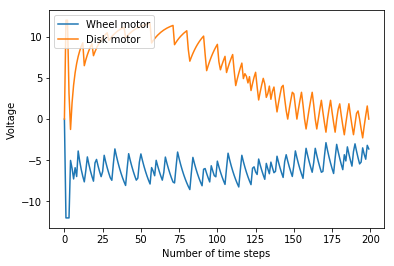

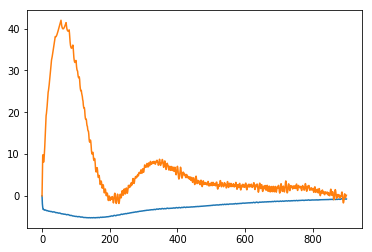

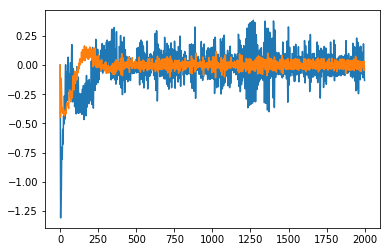

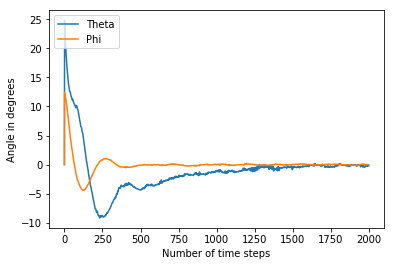

In [23]:
new_theta = [n*180/np.pi for n in theta]
new_phi = [n*180/np.pi for n in phi]


plt.plot(u_w[0:200],label='Wheel motor')
plt.plot(u_d[0:200], label='Disk motor')
plt.xlabel('Number of time steps')
plt.ylabel('Voltage')
plt.legend(loc='upper left')
#plt.savefig('plots/input_voltage.png')
plt.show()

plt.plot(dalpha_w[0:900])
plt.plot(dalpha_d[0:900])
plt.show()

plt.plot(dtheta[0:2000])
plt.plot(dphi[0:2000])
plt.show()

plt.plot(new_theta[0:2000], label='Theta')
plt.plot(new_phi[0:2000], label='Phi')
plt.xlabel('Number of time steps')
plt.ylabel('Angle in degrees')
plt.legend(loc='upper left')
#plt.savefig('plots/theta_phi.png')
plt.show()
